<a href="https://colab.research.google.com/github/shivanshus/Emotion-DeepDream-Machine/blob/master/EDM_Caffe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Asset 2

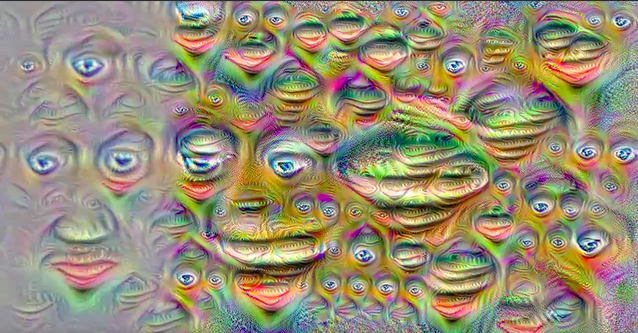

In [ ]:
!apt install -y caffe-cuda
!apt dist-upgrade

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  caffe-tools-cuda cython3 fonts-lyx javascript-common libblosc1
  libcaffe-cuda1 libcublas9.1 libcudart9.1 libcurand9.1 libgflags2.2
  libgoogle-glog0v5 libjs-jquery libjs-jquery-ui libleveldb1v5 liblmdb0
  python-matplotlib-data python-tables-data python3-bs4 python3-caffe-cuda
  python3-chardet python3-cycler python3-dateutil python3-decorator
  python3-gflags python3-h5py python3-html5lib python3-ipython
  python3-ipython-genutils python3-leveldb python3-lxml python3-matplotlib
  python3-networkx python3-nose python3-numexpr python3-olefile python3-pandas
  python3-pandas-lib python3-pexpect python3-pickleshare python3-pil
  python3-pkg-resources python3-prompt-toolkit python3-protobuf
  python3-ptyproc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ffmpeg -i  "/content/drive/My Drive/testing.mp4" -f image2 "/content/drive/My Drive/test/image-%06d.png"
#video to frame conversion done in test folder

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [ ]:

import argparse
import time
import os
import errno
import subprocess
import math

import numpy as np
import scipy.ndimage as nd
import PIL.Image
from google.protobuf import text_format

import caffe

In [ ]:
def preprocess(net, img):
    #print np.float32(img).shape
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']

def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def objective_L2(dst, targetId):
    dst.diff[:] = dst.data

def objectiveTarget(dst, targetId):
    ## category ID
    ## https://www.reddit.com/r/deepdream/comments/3cqetq/whats_the_best_way_to_visualize_certain_imagenet/
    Y = targetId 
    dst.diff[:] = -dst.data
    dst.diff[0,Y] += 1.0

# First we implement a basic gradient ascent step function, applying the first two tricks // 32:
def make_step(net, step_size=1.5, end='pool2', jitter=32, clip=True, objective=objective_L2, targetId=0):
    '''Basic gradient ascent step.'''
    end = 'pool2'
    src = net.blobs['data']  # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter + 1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2)  # apply jitter shift

    net.forward(end=end)
   
    objective(dst, targetId)  # specify the optimization objective
    
    net.backward(start=end)
    g = src.diff[0]
    
    # apply normalized ascent step to the input image
    src.data[:] += step_size / np.abs(g).mean() * g
    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2)  # unshift image

    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255 - bias)


def deepdream(net, base_img, iter_n=10, octave_n=4, step_size=1.5, octave_scale=1.4, jitter=32,
              end='pool2', clip=True, objective=objective_L2, targetId=0, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1])  # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0 * h / h1, 1.0 * w / w1), order=1)

        src.reshape(1, 3, h, w)  # resize the network's input image size
        src.data[0] = octave_base + detail
        for i in range(iter_n):
            make_step(net, end=end, step_size=step_size, jitter=jitter, clip=clip, objective=objective, targetId=targetId, **step_params)

            # visualization
            vis = deprocess(net, src.data[0])
            if not clip:  # adjust image contrast if clipping is disabled
                vis = vis * (255.0 / np.percentile(vis, 99.98))
            print (octave, i, end, vis.shape)

        # extract details produced on the current octave
        detail = src.data[0] - octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])


            
def deepdreamHalf(net, base_img, iter_n=10, octave_n=4, step_size=1.5, octave_scale=1.4, end='pool2', clip=True, verbose = 1, maxWidth=1500, objective=objective_L2, targetId=0, **step_params):

    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in range(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data'] 
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]): # itterating backward
        h, w = octave_base.shape[-2:] 
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        # make the image half if the image is larger than maximum size
        # reshape src accordingly
        if w > maxWidth:
            temp_data = np.zeros_like(octave_base)
            for i1 in range(0,2):
                for j1 in range(0,2):
                    spl_detail = detail[:,i1*h/2:(i1+1)*h/2, j1*w/2:(j1+1)*w/2]
                    spl_octave_base = octave_base[:,i1*h/2:(i1+1)*h/2, j1*w/2:(j1+1)*w/2]
                    
                    h_s, w_s = spl_octave_base.shape[-2:]
                    src.reshape(1,3,h_s,w_s) 
                    src.data[0] = spl_octave_base+spl_detail
                    for i in range(iter_n):
                        make_step(net, end=end, step_size=step_size, clip=clip, objective=objective, targetId=targetId, **step_params)
     
                        vis = deprocess(net, src.data[0])
                        if not clip: # adjust image contrast if clipping is disabled
                            vis = vis*(255.0/np.percentile(vis, 99.98))
          
                    detail[:,i1*h/2:(i1+1)*h/2, j1*w/2:(j1+1)*w/2] = spl_detail
                    octave_base[:,i1*h/2:(i1+1)*h/2, j1*w/2:(j1+1)*w/2] = spl_octave_base
                    temp_data[:,i1*h/2:(i1+1)*h/2, j1*w/2:(j1+1)*w/2] = src.data[0]
            #combine toghether
            src.reshape(1,3,h,w)
            src.data[0] = temp_data;
        else:
            src.reshape(1,3,h,w) 
            src.data[0] = octave_base+detail
            for i in range(iter_n):
                make_step(net, end=end, clip=clip, objective=objective, **step_params)
            
                vis = deprocess(net, src.data[0])
                if not clip: 
                    vis = vis*(255.0/np.percentile(vis, 99.98))
              
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
        
    # returning the resulting image
    return deprocess(net, src.data[0])


def deepdreamDivide(net, base_img, iter_n=10, octave_n=4, step_size=1.5, octave_scale=1.4, end='pool2', clip=True, verbose = 1, maxWidth=512, maxHeight=512, objective=objective_L2, targetId=0, **step_params):

    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    
    for i in range(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data'] 
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]): # itterating backward
        h, w = octave_base.shape[-2:]  
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        print ("octave=", octave, w, h)
		# devide image into sub images if the image is larger than maximum size
        if w > maxWidth or h > maxHeight:
            temp_data = np.zeros_like(octave_base)
            
            numX = int(math.ceil(float(w) / float(maxWidth))) ;
            numY = int(math.ceil(float(h) / float(maxHeight))) ;
			
            for i1 in range(0,numY):
                for j1 in range(0,numX):
                    
                    x0 = j1*maxWidth
                    x1 = (j1+1)*maxWidth
                    y0 = i1*maxHeight
                    y1 = (i1+1)*maxHeight
                    
                    spl_detail = detail[:, y0:y1,x0:x1]
                    spl_octave_base = octave_base[:, y0:y1,x0:x1]
                    
                    h_s, w_s = spl_octave_base.shape[-2:]
					
                    src.reshape(1,3,h_s,w_s) 
                    src.data[0] = spl_octave_base+spl_detail  
                    for i in range(iter_n):
                        make_step(net, end=end, step_size=step_size, clip=clip, objective=objective, targetId=targetId, **step_params)
                    
                    detail[:, y0:y1,x0:x1] = spl_detail
                    octave_base[:, y0:y1,x0:x1] = spl_octave_base
                    temp_data[:, y0:y1,x0:x1] = src.data[0]

            src.reshape(1,3,h,w)
            src.data[0] = temp_data;
        else:
            src.reshape(1,3,h,w) 
            src.data[0] = octave_base+detail  
            for i in range(iter_n):
                make_step(net, end=end, clip=clip, objective=objective, targetId=targetId, **step_params)
 
                vis = deprocess(net, src.data[0])
                if not clip: 
                    vis = vis*(255.0/np.percentile(vis, 99.98))
      
        detail = src.data[0]-octave_base
        
    return deprocess(net, src.data[0])
    

# Animaton functions

def resizePicture(image, width):
    img = PIL.Image.open(image)
    basewidth = width
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    return img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)    


def morphPicture(filename1, filename2, blend, width):
    img1 = PIL.Image.open(filename1)
    img2 = PIL.Image.open(filename2)
    if width is not 0:
        img2 = resizePicture(filename2, width)
    return PIL.Image.blend(img1, img2, blend)


def make_sure_path_exists(path):
    # make sure input and output directory exist, if not create them. If another error (permission denied) throw an error.
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def saveImage(outputdir, image, filename, index):
    save_filename = outputdir + '/' + filename + '_%06d.png' % index
    PIL.Image.fromarray(np.uint8(image)).save(save_filename)


In [ ]:

def main(inputdir, outputdir, preview, octaves, octave_scale, iterations, jitter, zoom, stepsize, blendflow, blendstatic, layers, guide, gpu, flow, flowthresh, divide, maxWidth, maxHeight):
    # input var setup
    make_sure_path_exists(inputdir)
    make_sure_path_exists(outputdir)
    if preview is None: preview = 0
    if octaves is None: octaves = 4
    if octave_scale is None: octave_scale = 1.5
    if iterations is None: iterations = 10
    if jitter is None: jitter = 32
    if zoom is None: zoom = 1
    if stepsize is None: stepsize = 1.5
    if blendflow is None: blendflow = 0.75
    if blendstatic is None: blendstatic = 0.1
    if layers is None: layers = ['pool2']
    if gpu is None: gpu = 1
    if flow is None: flow = 0
    if flowthresh is None: flow = 10
    if divide is None: divide = 0
    # net.blobs.keys()


    # Loading DNN model
    #model_name = 'bvlc_googlenet'
    #model_path = '../caffe/models/' + model_name + '/'
    
    #net_fn = '/content/drive/My Drive/deploy.prototxt'
    #param_fn = '/content/drive/My Drive/bvlc_googlenet.caffemodel'

    net_fn = '/content/drive/My Drive/deploy (1).prototxt'
    param_fn = '/content/drive/My Drive/EmotiW_VGG_S.caffemodel'

    #net_fn = '/content/drive/My Drive/ResNet-101-deploy_augmentation.prototxt'
    #param_fn='/content/drive/My Drive/snap_resnet__iter_120000.caffemodel'


    # Patching model to be able to compute gradients.
    # Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
    model = caffe.io.caffe_pb2.NetParameter()
    text_format.Merge(open(net_fn).read(), model)
    model.force_backward = True
    open('tmp.prototxt', 'w').write(str(model))

    net = caffe.Classifier('tmp.prototxt', param_fn,
                           mean=np.float32([104.0, 116.0, 122.0]),  # ImageNet mean, training set dependent
                           channel_swap=(2, 1, 0))  # the reference model has channels in BGR order instead of RGB

    if gpu is 1:
        caffe.set_mode_gpu()
        caffe.set_device(0)

    # load images & sort them
    vidinput = os.listdir(inputdir)
    #vidinput = natsort.natsorted(os.listdir(inputdir))
    vids = []
    var_counter = 1

    # create list
    for frame in vidinput:
        # if not ".png" in frame: continue
        vids.append(frame)
	
    img = PIL.Image.open(inputdir + '/' + vids[0])
    if preview is not 0:
        img = resizePicture(inputdir + '/' + vids[0], preview)
    frame = np.float32(img)

    # guide
    if guide is not None:
        guideimg = PIL.Image.open(inputdir + '/' + guide)
        guideimgresized = guideimg.resize((224, 224), PIL.Image.ANTIALIAS)
        guide = np.float32(guideimgresized)
        end = layers[0]  # 'inception_3b/output'
        h, w = guide.shape[:2]
        src, dst = net.blobs['data'], net.blobs[end]
        src.reshape(1, 3, h, w)
        src.data[0] = preprocess(net, guide)
        net.forward(end=end)
        guide_features = dst.data[0].copy()


    def objective_guide(dst, targetId):
        x = dst.data[0].copy()
        y = guide_features
        ch = x.shape[0]
        x = x.reshape(ch, -1)
        y = y.reshape(ch, -1)
        A = x.T.dot(y)  # compute the matrix of dot-products with guide features
        dst.diff[0].reshape(ch, -1)[:] = y[:, A.argmax(1)]  # select ones that match best

    def getFrame(net, frame, itr, endparam, objective=objective_L2):
        # dream frame
        if divide == 0:
            return deepdream(net, frame, iter_n=itr, step_size=stepsize, octave_n=octaves, octave_scale=octave_scale, jitter=jitter, end=endparam, objective=objective)
        elif divide == 1:
            return deepdreamDivide(net, frame, iter_n=itr, step_size=stepsize, octave_n=octaves, octave_scale=octave_scale, jitter=jitter, end=endparam, objective=objective, maxWidth=maxWidth, maxHeight=maxHeight)
        elif divide == 2:
            return deepdreamHalf(net, frame, iter_n=itr, step_size=stepsize, octave_n=octaves, octave_scale=octave_scale, jitter=jitter, objective=objective, end=endparam, maxWidth=maxWidth )
                

    def getStats(saveframe, var_counter, vids, difference):
        # Stats
        print ('***************************************')
        print ('Saving Image As: ' + saveframe)
        print ('Frame ' + str(var_counter) + ' of ' + str(len(vids)))
        print ('Frame Time: ' + str(difference) + 's')
        timeleft = difference * (len(vids) - var_counter)
        m, s = divmod(timeleft, 60)
        h, m = divmod(m, 60)
        print ('Estimated Total Time Remaining: ' + str(timeleft) + 's (' + "%d:%02d:%02d" % (h, m, s) + ')')
        print ('***************************************')

    if flow is 1:
        import cv2

        # optical flow
        img = np.float32(PIL.Image.open(inputdir + '/' + vids[0]))
        h, w, c = img.shape
        if guide is None:
            hallu = getFrame(net, img, iterations, layers[0])
        else:
            hallu = getFrame(net, img, iterations, layers[0], objective_guide)
                
        np.clip(hallu, 0, 255, out=hallu)
        saveframe = outputdir + '/' + 'frame_000000.png'
        PIL.Image.fromarray(np.uint8(hallu)).save(saveframe)
        grayImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        for v in range(len(vids)):
            if var_counter < len(vids):
                previousImg = img
                previousGrayImg = grayImg

                newframe = inputdir + '/' + vids[v + 1]
                print ('Processing: ' + newframe)
                endparam = layers[var_counter % len(layers)]

                ## calclurating optical flows
                img = np.float32(PIL.Image.open(newframe))
                grayImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                flow = cv2.calcOpticalFlowFarneback(previousGrayImg, grayImg,None, pyr_scale=0.5, levels=3, winsize=15,
                                                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
                
                inv_flow = flow;
                
                flow = -flow
                flow[:, :, 0] += np.arange(w)
                flow[:, :, 1] += np.arange(h)[:, np.newaxis]

                ## the area on the optical flow is shifted and merged into the current frame
                if blendflow == 0:
                    halludiff = previousImg - previousImg
                else:
                    preframe = inputdir + '/' + vids[v]
                    halludiff = morphPicture(preframe, saveframe, blendflow, preview) - previousImg

                halludiff = cv2.remap(halludiff, flow, None, cv2.INTER_LINEAR)
                
                hallu_flow = img + halludiff
       
                ## create a mask from the optical flow
                magnitude, angle = cv2.cartToPolar(inv_flow[...,0], inv_flow[...,1])
                norm_mag = cv2.normalize(magnitude,None,0,255,cv2.NORM_MINMAX);
                ret, mask = cv2.threshold(norm_mag, flowthresh, 255, cv2.THRESH_BINARY);
                flow_mask = mask.astype(np.uint8).reshape((h,w,1))
        
            	## apply the mask to the optical flow
                hallu_flow_masked = cv2.bitwise_and(hallu_flow, hallu_flow, mask=flow_mask )

            	## blending the are with no optical flow 
                background_blendimg = cv2.addWeighted( img, (1-blendstatic), hallu, blendstatic, 0)
                background_masked =  cv2.bitwise_and(background_blendimg, background_blendimg, mask=cv2.bitwise_not(flow_mask))
                
            	## combine the optical flow and the background
                hallu = hallu_flow_masked + background_masked
           
                now = time.time()
                 
                if guide is None:
                    hallu = getFrame(net, hallu, iterations, endparam)
                else:
                    hallu = getFrame(net, hallu, iterations, endparam, objective_guide)
                    
                later = time.time()
                difference = int(later - now)

                saveframe = outputdir + '/' + 'frame_%06d.png' % (var_counter)
                getStats(saveframe, var_counter, vids, difference)

                np.clip(hallu, 0, 255, out=hallu)
                PIL.Image.fromarray(np.uint8(hallu)).save(saveframe)
                var_counter += 1
            else:
                print ('Finished processing all frames')
    else:
        # process anim frames
        for v in range(len(vids)):
            if var_counter < len(vids):
                vid = vids[v]
                h, w = frame.shape[:2]
                s = 0.05  # scale coefficient  

                print ('Processing: ' + inputdir + '/' + vid)

                # setup
                now = time.time()
                endparam = layers[var_counter % len(layers)]
                
                if var_counter < iterations:
                   frame = getFrame(net, frame, var_counter, endparam)
                else:
                   frame = getFrame(net, frame, iterations, endparam)

                later = time.time()
                difference = int(later - now)
                saveframe = outputdir + '/' + 'frame_%06d.png' % (var_counter)
                getStats(saveframe, var_counter, vids, difference)

                # save image
                PIL.Image.fromarray(np.uint8(frame)).save(saveframe)

                # setup next image
                newframe = inputdir + '/' + vids[v + 1]

                # blend
                if blendstatic == 0:
                    newimg = PIL.Image.open(newframe)
                    if preview is not 0:
                        newimg = resizePicture(newframe, preview)
                    frame = newimg
                else:
                    frame = morphPicture(saveframe, newframe, blendstatic, preview)

                # setup next frame
                frame = np.float32(frame)
                var_counter += 1
            else:
                print ('Finished processing all frames')


def extractVideo(inputdir, outputdir):
    print (subprocess.Popen('ffmpeg -i ' + inputdir + ' -f image2 ' + outputdir + '/image-%06d.png', shell=True,
                           stdout=subprocess.PIPE).stdout.read())


def createVideo(inputdir, outputdir, framerate):
    print (subprocess.Popen('ffmpeg -r ' + str(
        framerate) + ' -f image2 -i "' + inputdir + '/frame_%6d.png" -c:v libx264 -crf 20 -pix_fmt yuv420p -tune fastdecode -tune zerolatency -profile:v baseline ' + outputdir,
                           shell=True, stdout=subprocess.PIPE).stdout.read())


In [ ]:
main('/content/drive/My Drive/test', '/content/drive/My Drive/output_pool2', preview=0, octaves=5, octave_scale=2.5, iterations=25, jitter=32, zoom=1, stepsize=1.0, blendflow=0.9, blendstatic=0.1, layers='pool2', guide=None, gpu=1, flow=1, flowthresh=6, divide=1, maxWidth=1500, maxHeight=1600)

octave= 0 49 28
octave= 1 123 69
octave= 2 307 173
octave= 3 768 432
octave= 4 1920 1080
Processing: /content/drive/My Drive/test/image-000002.png
octave= 0 49 28
octave= 1 123 69
octave= 2 307 173
octave= 3 768 432
octave= 4 1920 1080
***************************************
Saving Image As: /content/drive/My Drive/output_pool2/frame_000001.png
Frame 1 of 84
Frame Time: 6s
Estimated Total Time Remaining: 498s (0:08:18)
***************************************
Processing: /content/drive/My Drive/test/image-000008.png
octave= 0 49 28
octave= 1 123 69
octave= 2 307 173
octave= 3 768 432
octave= 4 1920 1080
***************************************
Saving Image As: /content/drive/My Drive/output_pool2/frame_000002.png
Frame 2 of 84
Frame Time: 6s
Estimated Total Time Remaining: 492s (0:08:12)
***************************************
Processing: /content/drive/My Drive/test/image-000011.png
octave= 0 49 28
octave= 1 123 69
octave= 2 307 173
octave= 3 768 432
octave= 4 1920 1080
****************

In [ ]:
!ffmpeg -r 25 -f image2 -i "/content/drive/My Drive/output/frame_%6d.png" -c:v libx264 -crf 20 -pix_fmt yuv420p -tune fastdecode -tune zerolatency -profile:v baseline "/content/caffe_face_pool2.mp4"
# also done in config folder

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena